In [1]:
library(mlbench)
library(stats)

"%^%" <- function(M, power)
  with(eigen(M), vectors %*% (values^power * solve(vectors)))

In [2]:
#library(mlbench)

#set.seed(1,)
#objekt <- mlbench.spirals(100,1,0.025)
#podatki <- objekt$x
#plot(podatki)

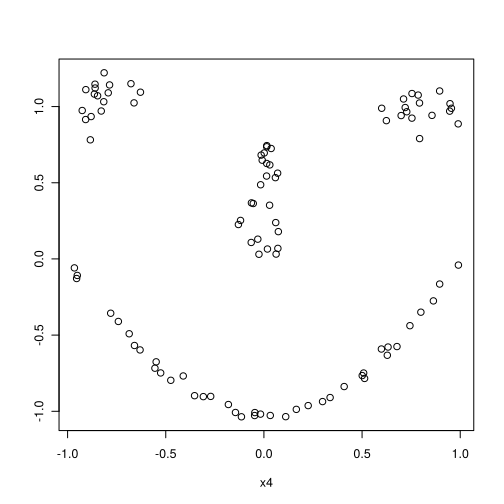

In [20]:
library(mlbench)

set.seed(5)
objekt <- mlbench.smiley(n=100, sd1 = 0.1, sd2 = 0.025)
podatki <-  objekt$x
plot(podatki)

In [21]:
s <- function(x1, x2, alpha=1) {
    exp(- alpha * norm(as.matrix(x1-x2), type="F")) #frobeniusova norma
}

In [22]:
podobnostna.matrika <- function(podatki, razdalja, r = 1) {
  N <- nrow(podatki)
  S <- matrix(rep(NA,N^2), ncol=N) #ustvarim prazno matriko
  for(i in 1:N) {
    for(j in 1:N) {
        if (norm(as.matrix(podatki[i,]-podatki[j,]), type="F") >= r) {
            S[i,j] <- 0
        } else {
            S[i,j] <- razdalja(podatki[i,], podatki[j,])
       }
    }
  }
  S
}

In [23]:
podobnostna.matrika.epsilon <- function(podatki, epsilon = 0.5) {
  N <- nrow(podatki)
  S <- matrix(rep(NA,N^2), ncol=N) #ustvarim prazno matriko
  for(i in 1:N) {
    for(j in 1:N) {
        if (norm(as.matrix(podatki[i,]-podatki[j,]), type="F") > epsilon ) {
            S[i,j] <- 0
        } else {
            S[i,j] <- 1 #lahko tudi gaussian kernell
       }
    }
  }
  S
}

In [24]:
S <- podobnostna.matrika(podatki, s)
#S[1:8,1:8]
S.epsilon <- podobnostna.matrika.epsilon(podatki)

In [25]:
affinity.matrika <- function(S, st.sosedov=length(S[,1])) {
  N <- length(S[,1])

  if (st.sosedov >= N) { #poln graf
    A <- S
  } else {
    A <- matrix(rep(0,N^2), ncol=N) #prazna matrika
    for(i in 1:N) {
      najboljsa.ujemanja <- sort(S[i,], decreasing=TRUE)[1:st.sosedov] #povezem tiste, kateri so blizji
      for (s in najboljsa.ujemanja) {
        j <- which(S[i,] == s)
        A[i,j] <- S[i,j]
        A[j,i] <- S[i,j] #simetricna matrika - neusmerjen graf
      }
    }
  }
  A
}


In [37]:
A <- affinity.matrika(S, 4) #povezem tiste, ki imajo visoke vrednosti
#A[1:8,1:8]

In [38]:
D <- diag(apply(A, 1, sum))
#D[1:8,1:8]
D.epsilon <- diag(apply(S.epsilon, 1, sum))

Poracunam normalizirano Laplaceovo matriko (symmetric matrix = $D^{-1/2}*U*D^{-1/2}$)

In [39]:
U <- D - A
U.epsilon <- D.epsilon - S.epsilon

In [40]:
Lsym <- (D %^% (-1/2)) %*% U %*% (D %^% (-1/2))
#round(Lsym[1:10,1:10],1)
Lsym.epsilon <- (D.epsilon %^% (-1/2)) %*% U.epsilon %*% (D.epsilon %^% (-1/2))

In [41]:
k <- 4

In [42]:
lastne_vrednosti <- eigen(Lsym, symmetric = TRUE)
Z   <- lastne_vrednosti$vectors[,(ncol(lastne_vrednosti$vectors)-k+1):ncol(lastne_vrednosti$vectors)]

lastne_vrednosti.epsilon <- eigen(Lsym.epsilon, symmetric = TRUE)
Z.epsilon   <- lastne_vrednosti.epsilon$vectors[,(ncol(lastne_vrednosti.epsilon$vectors)-k+1):ncol(lastne_vrednosti.epsilon$vectors)]

Formuliramo novo matriko, ki ima normalizirane vrstice: $t_{ij}=z_{ij}/(\sum_{k}z_{ik}^{2})^{1/2}$

In [43]:
normal.matrika <- function(Z, k) {
    T <- matrix(rep(0,k*nrow(Z)), ncol=k)
    Q <- matrix(rep(0,k*nrow(Z)), ncol=k)
    for(i in 1:nrow(Z)) {
          for (j in 1:k) {
            Q[i,j] = Z[i,j]^2
           }
          }

    for(i in 1:nrow(Z)) {
        suma = sqrt(sum(Q[i,]))
          for (j in 1:k) {
            if (suma == 0) {
                T[i,j] <- 0
            } else {
                T[i,j] <- Z[i,j]/suma
           }
          }
        }
    T
}
T = normal.matrika(Z, k)
T.epsilon = normal.matrika(Z.epsilon, k)

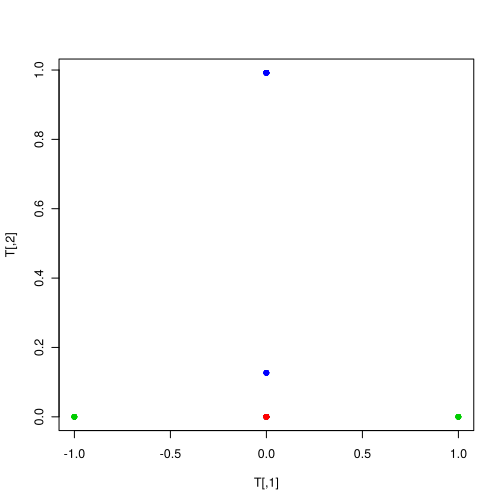

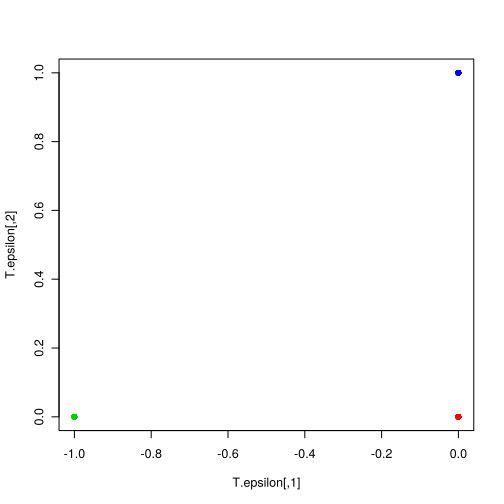

In [44]:
plot(T, col=objekt$classes, pch=20)
plot(T.epsilon, col=objekt$classes, pch=20)

Uporabim k-means algoritem.

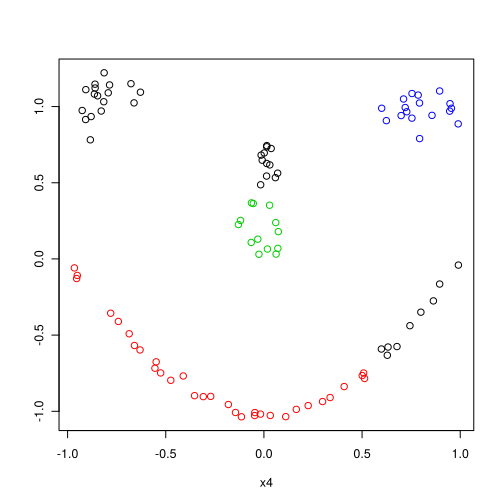

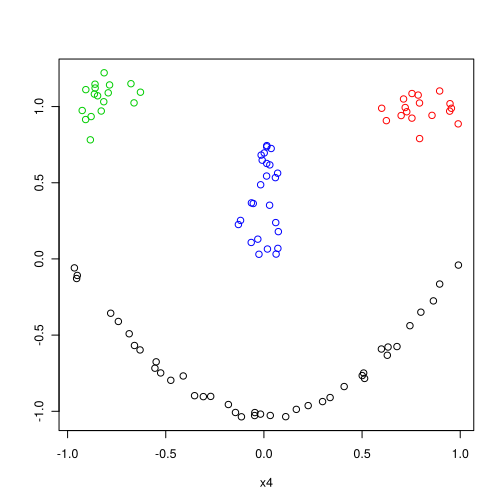

In [45]:
km <- kmeans(T, centers=k)
plot(podatki, col=km$cluster)

km.epsilon <- kmeans(T.epsilon, centers=k)
plot(podatki, col=km.epsilon$cluster)

In [0]:
lastne_vrednosti$values[lastne_vrednosti$values <= 0] <- 1e-16 #problem negativnih lastnih vrednosti
#signif(lastne_vrednosti$values,2) #absolutne lastne vrednosti, saj pridejo nekatere negativne

lastne_vrednosti.epsilon$values[lastne_vrednosti.epsilon$values <= 0] <- 1e-16

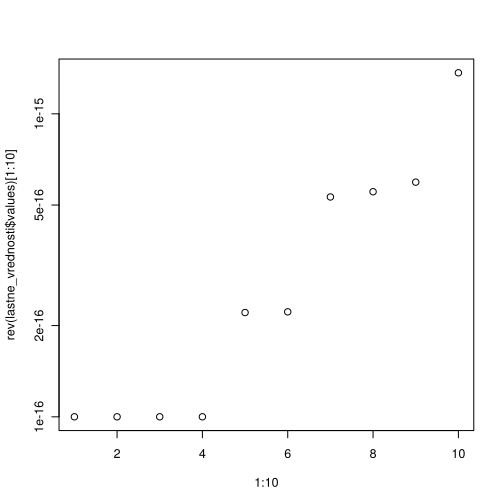

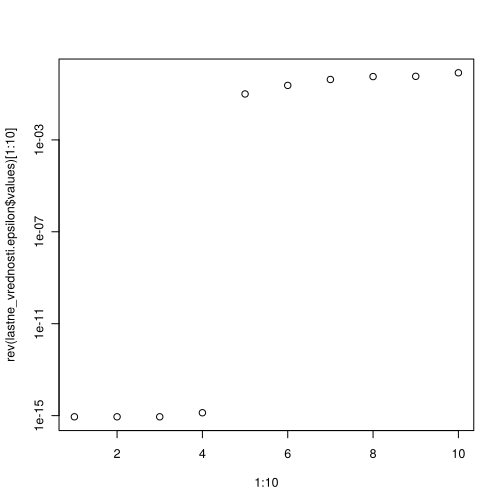

In [36]:
plot(1:10, rev(lastne_vrednosti$values)[1:10], log = "y")
plot(1:10, rev(lastne_vrednosti.epsilon$values)[1:10], log = "y")